## Import & Data Load

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor


train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [22]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['hour'] = df['ATA'].dt.hour
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns=['ATA','ID','SHIPMANAGER','FLAG'], inplace=True)
test.drop(columns=['ATA','ID','SHIPMANAGER','FLAG'], inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"): #tqdm? 진행상황 표시 
    le = LabelEncoder() # 카테고리 데이터들을 수치형 데이터로 변환
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_) # 클래스 집합 생성
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist() # 객체 클래스 리스트 생성
    bisect.insort_left(le_classes, '-1') # -1을 리스트에 삽입
    le.classes_ = np.array(le_classes) 
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

train = pd.get_dummies(train,columns=['SHIP_TYPE_CATEGORY'])
test = pd.get_dummies(test,columns=['SHIP_TYPE_CATEGORY'])
# [배 수치항목서 결측치 존재하는 행 제거]
train.dropna(subset=['LENGTH'], inplace=True)
# BUILT,U_WIND,V_WIND 열 제거
train.drop(columns=['BUILT','U_WIND','V_WIND'],axis=1,inplace=True)
test.drop(columns=['BUILT','U_WIND','V_WIND'],axis=1,inplace=True)


Encoding features: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


In [23]:
# 결측치가 있는 행과 없는 행 분리
X_missing = train[train.isnull().any(axis=1)]
X_no_missing = train.dropna()

# 결측치가 없는 데이터의 특성과 타겟 분리
y_train = X_no_missing[['BN','AIR_TEMPERATURE']]
X_train = X_no_missing[['ARI_CO','ARI_PO','ATA_LT']]


# 결측치가 있는 데이터에서 예측할 특성 분리
X_missing_test = X_missing[['ARI_CO','ARI_PO','ATA_LT']]

# KNN 회귀 모델 생성 및 훈련
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)

# 결측치 예측
predicted_values = knn_regressor.predict(X_missing_test)

# BN 열과 air_temperature 열의 결측치 인덱스 찾기
bn_nan_indices = train.index[train['BN'].isna()]
air_temp_nan_indices = train.index[train['AIR_TEMPERATURE'].isna()]

# BN 열의 결측치 채우기
for i, idx in enumerate(bn_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'BN'] = predicted_values[i, 0]

# air_temperature 열의 결측치 채우기
for i, idx in enumerate(air_temp_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'AIR_TEMPERATURE'] = predicted_values[i, 1]


In [24]:
# 결측치 처리 여부
train.isna().sum()

ARI_CO                          0
ARI_PO                          0
DIST                            0
BREADTH                         0
DEADWEIGHT                      0
DEPTH                           0
DRAUGHT                         0
GT                              0
LENGTH                          0
AIR_TEMPERATURE                 0
BN                              0
ATA_LT                          0
PORT_SIZE                       0
CI_HOUR                         0
hour                            0
weekday                         0
SHIP_TYPE_CATEGORY_Bulk         0
SHIP_TYPE_CATEGORY_Cargo        0
SHIP_TYPE_CATEGORY_Container    0
SHIP_TYPE_CATEGORY_Tanker       0
dtype: int64

## 각 열의 boxplot을 통해 열 특성 확인

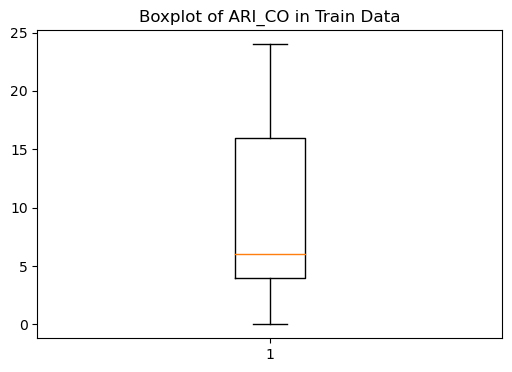

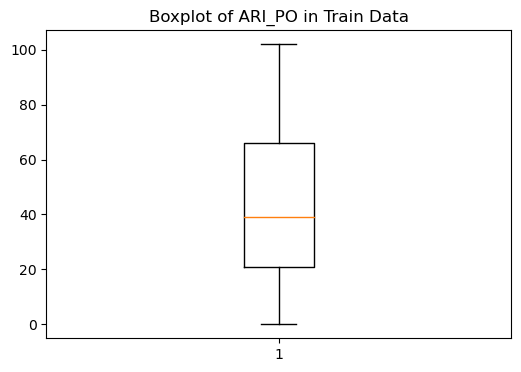

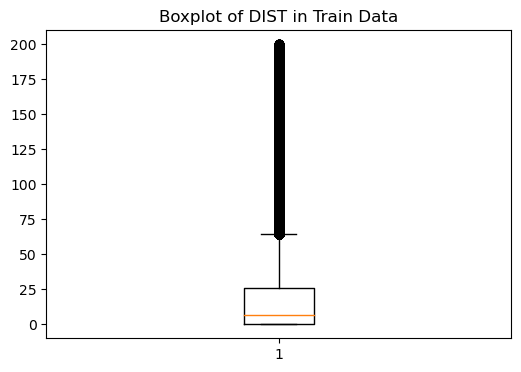

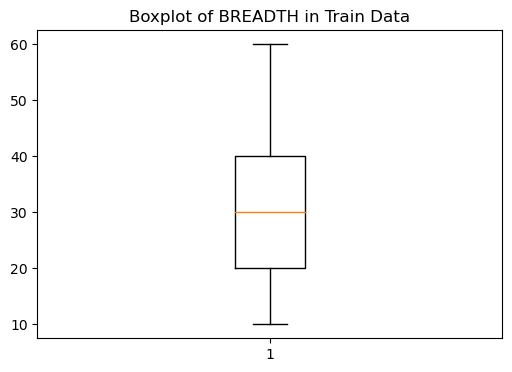

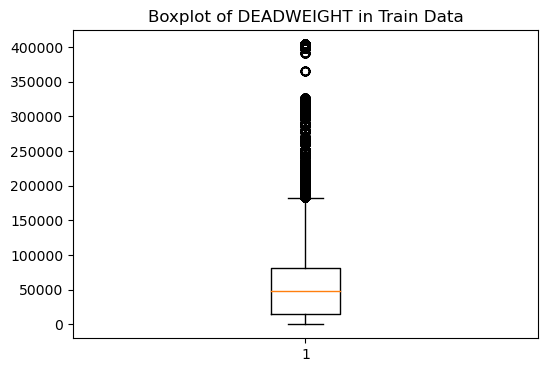

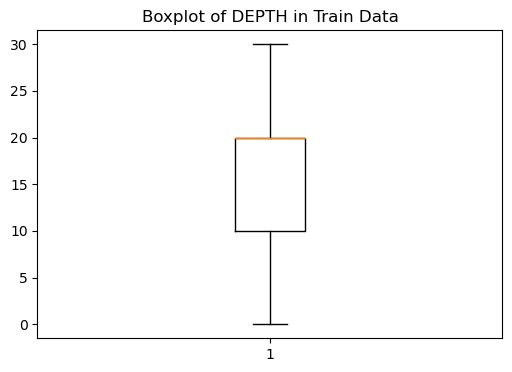

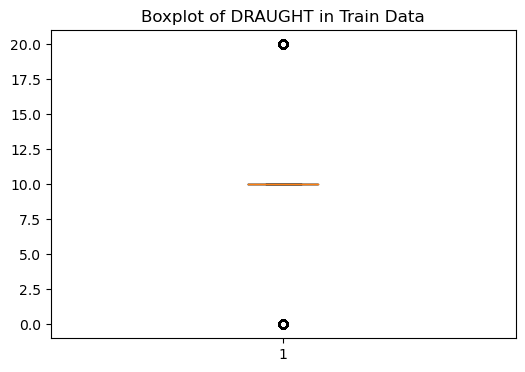

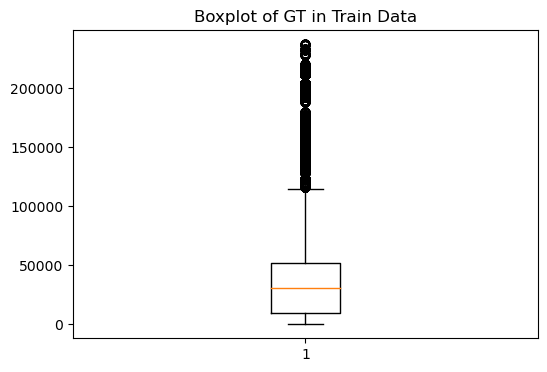

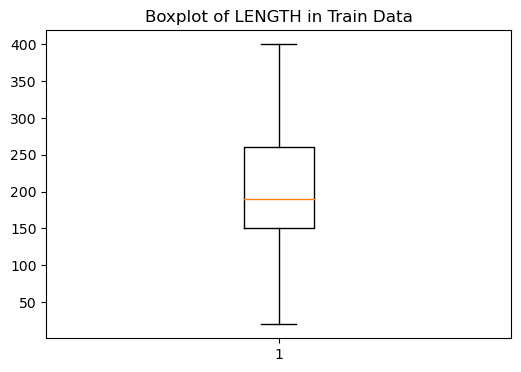

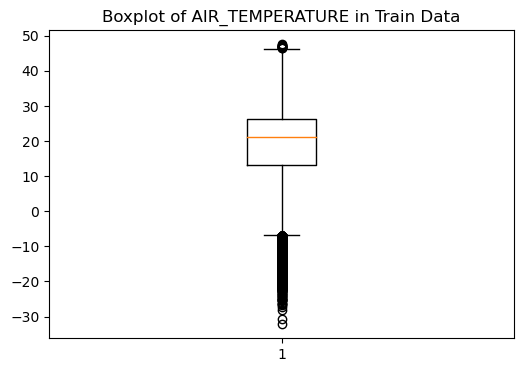

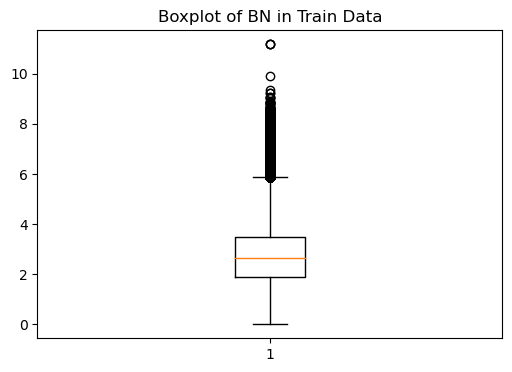

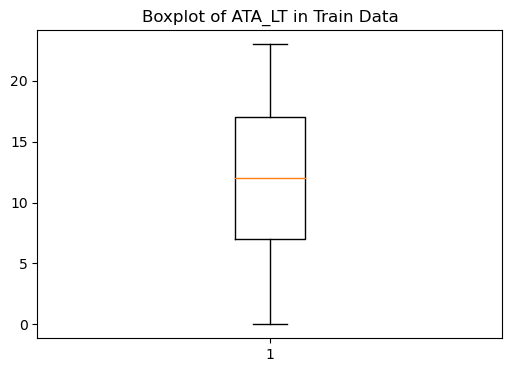

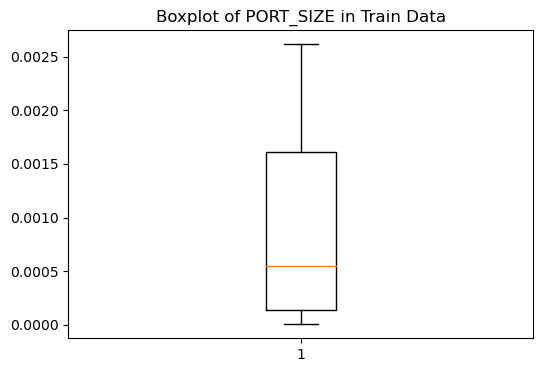

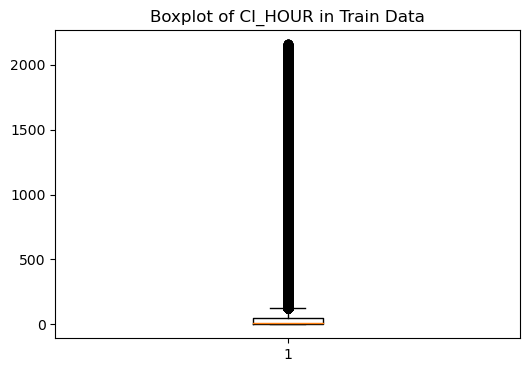

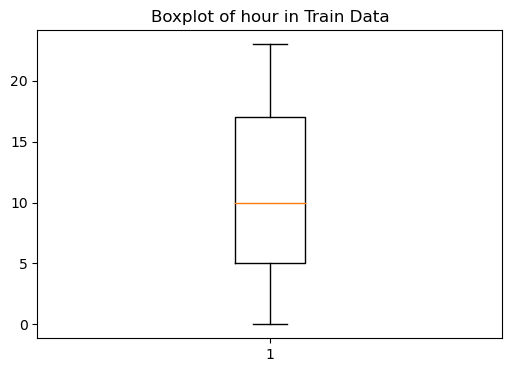

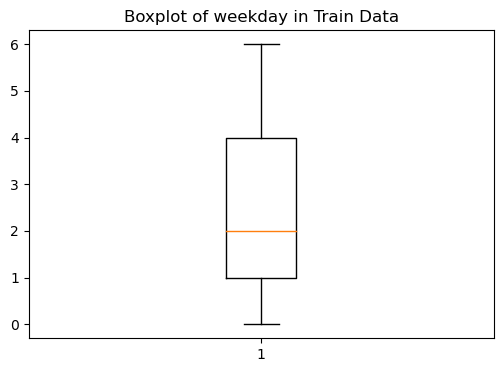

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

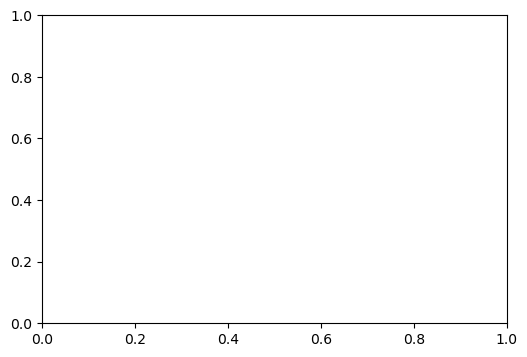

In [25]:
for feature in train.columns:
    plt.figure(figsize=(6, 4))  # 그래프의 크기 설정
    plt.boxplot(train[feature])  # 현재 feature에 대한 boxplot 그리기
    plt.title(f'Boxplot of {feature} in Train Data')  # 그래프 제목 설정
    plt.show()

## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 391938, number of used features: 19
[LightGBM] [Info] Start training from score 61.940993


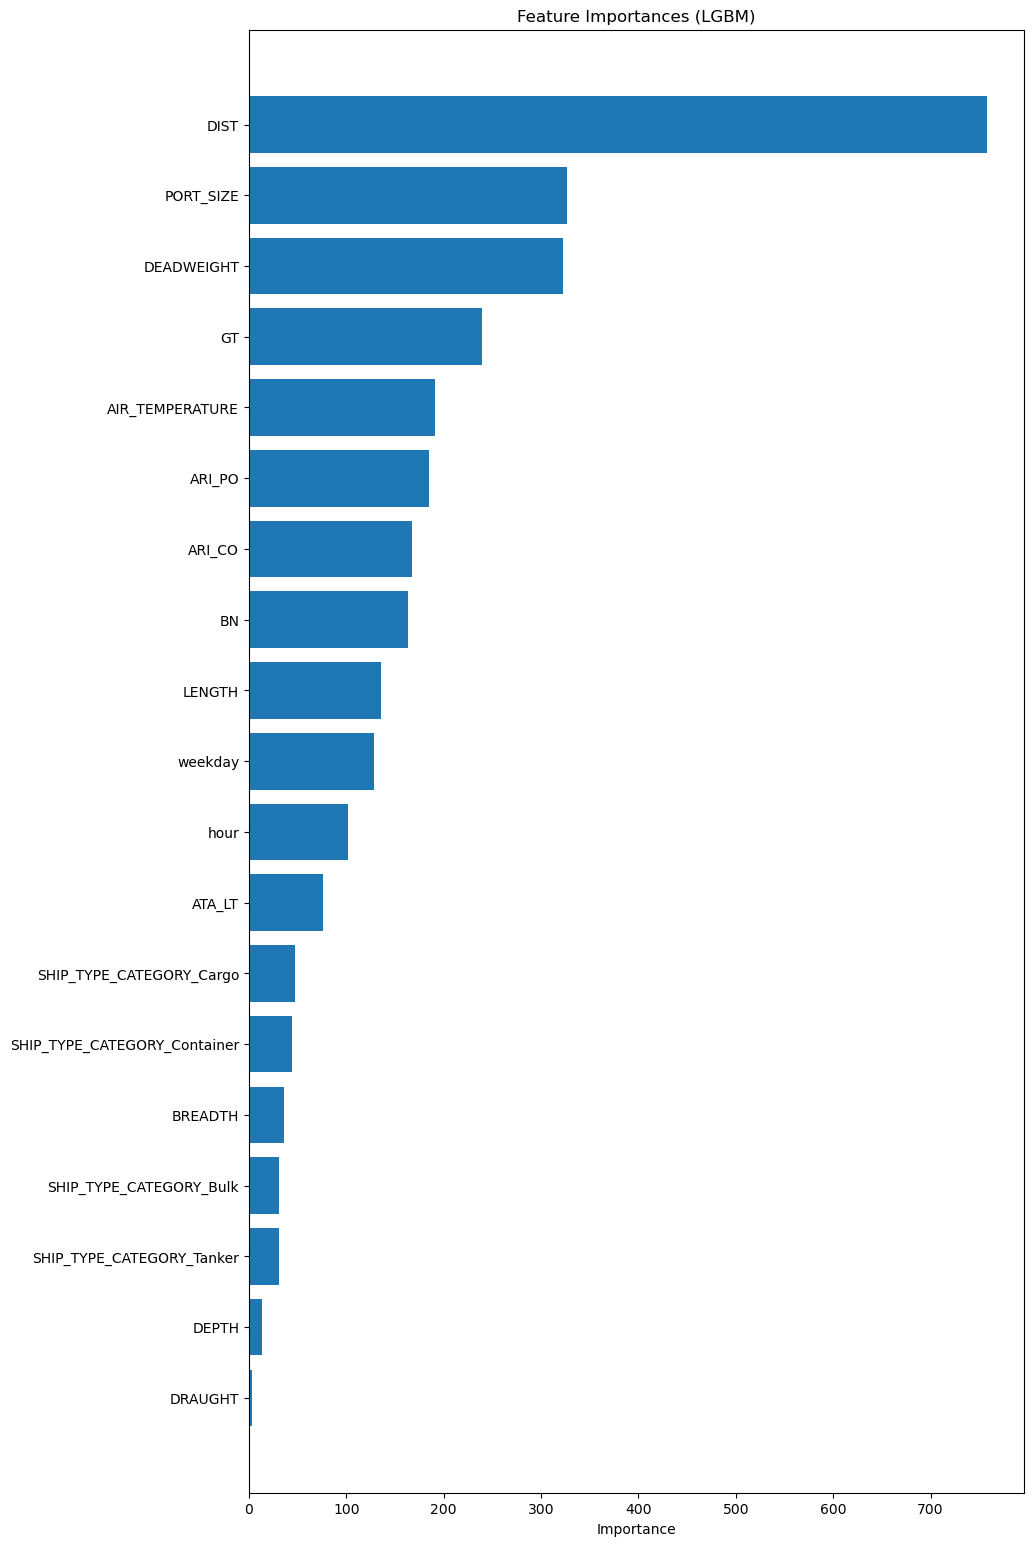

In [26]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [38]:
threshold = 20 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## K-Fold Model Fitting & Validation

In [39]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1613
[LightGBM] [Info] Number of data points in the train set: 313550, number of used features: 17
[LightGBM] [Info] Start training from score 62.051010


Processing folds:  20%|██        | 1/5 [00:00<00:03,  1.20it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1613
[LightGBM] [Info] Number of data points in the train set: 313550, number of used features: 17
[LightGBM] [Info] Start training from score 61.824749


Processing folds:  40%|████      | 2/5 [00:01<00:02,  1.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 313550, number of used features: 17
[LightGBM] [Info] Start training from score 61.734020


Processing folds:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 17
[LightGBM] [Info] Start training from score 62.101382


Processing folds:  80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1613
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 17
[LightGBM] [Info] Start training from score 61.993802


Processing folds: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

Validation : MAE scores for each fold: [55.747507766223556, 56.46502766232509, 56.57360037644668, 55.47301170268844, 55.61598083541735]
Validation : MAE: 55.97502566862022


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)